In [12]:
import numpy as np
from scipy import signal
from sklearn.model_selection import LeavePOut
import random
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP
from eeg_lib.utils import standardise
import matplotlib.pyplot as plt
import pandas as pd

def synth_x(f, Ns, noise_power=0.5, fs=256):
    t = np.arange(0, Ns/fs, 1/fs)
    return np.sin(t*2*np.pi*f)*(1+random.random()*noise_power)

SOS_SSVEP_BANDPASS_256HZ = np.array(
    [   [5.18442631e-04, 5.91022291e-04, 5.18442631e-04, 1.00000000e00, -1.58700686e00, 6.47826110e-01,],
        [1.00000000e00, -6.71721317e-01, 1.00000000e00, 1.00000000e00, -1.56164716e00, 7.42956116e-01,],
        [1.00000000e00, -1.19862825e00, 1.00000000e00, 1.00000000e00, -1.53434369e00, 8.53024717e-01,],
        [1.00000000e00, -1.36462221e00, 1.00000000e00, 1.00000000e00, -1.52074686e00, 9.31086238e-01,],
        [1.00000000e00, -1.41821305e00, 1.00000000e00, 1.00000000e00, -1.52570664e00, 9.80264626e-01,],
    ])

fs_openbci = 200
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs_openbci*0.5)
wc_hi = fc_hi/(fs_openbci*0.5)

sos_openbci = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')

def load_array_data(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [int(i) for i in data_file]
    return values

def load_array_data_float(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(', ')
    for i, v in enumerate(data_file):
        if '[' in v:
            data_file[i] = v.replace('[','')
        if ']\n' in v:
            data_file[i] = v.replace(']\n','')
            
    values = [float(i) for i in data_file]
    return values

def load_array_data_online(file_path):
    data_file = open(file_path, "r")
    data_file = data_file.read().split(',')            
    values = [float(i) for i in data_file]
    return values

def average_every_n(values, size):
#     return np.array([sum(group) / size for group in zip(*[iter(values)]*size)])
    return values[::size]

def sos_filter_OpenBCI(values):
    return signal.sosfilt(sos_openbci, values)

def sos_filter_256(values):
    return signal.sosfilt(SOS_SSVEP_BANDPASS_256HZ, values)

def process_data(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_256(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def process_data_OpenBCI(data, no_samples, no_train, remove_DC=True, apply_filter=False, ds_rate=1, downsample=False):

    data = data[:int(len(data)/no_samples)*no_samples]
    
    if remove_DC:
        data = data - sum(data)/len(data)
        if apply_filter:
            data = sos_filter_OpenBCI(data)[no_samples:]
            plt.plot(data[:256])
            
    if downsample:
        print("downsampling",len(data))
        data = average_every_n(data, ds_rate)
        print("to",len(data))
        data = data[:int(len(data)/no_samples)*no_samples]
        
    data_reshape = data.reshape(int(len(data)/no_samples),no_samples)
    data = data_reshape.T.reshape(1,no_samples,int(len(data)/no_samples))
    return np.array(data)

def prepare_data(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def prepare_data_OpenBCI(data, frequency, fs, fs_synth, no_samples, no_train, remove_DC=True, apply_filter=True, downsample=False, ds_avg=1, synth_power=0, noise_power=0):
    data = data + synth_power*synth_x(frequency, len(data), noise_power=0, fs=fs_synth)
    values = process_data_OpenBCI(data,no_samples,no_train,remove_DC=remove_DC,apply_filter=apply_filter,ds_rate=ds_avg,downsample=downsample)
    return values

def generate_train_test_idxs(data,no_train):
    lpo = LeavePOut(p=no_train)
    no_trials = data.shape[-1]
    return list(lpo.split(range(no_trials)))

def flatten(t):
    return [item for sublist in t for item in sublist]

def test_gcca_mset(data, data_idxs, freqs, fs, no_samples, number_runs=10):
    # Nf x Nc x Ns x Nt
    gcca = GCCA_SSVEP(freqs, fs, Nh=1)
    mset_cca = MsetCCA_SSVEP(freqs)
    gcca_total_acc = []
    mset_total_acc = []
    gcca_freq_acc = dict((key,[]) for key in freqs)
    mset_freq_acc = dict((key,[]) for key in freqs)

    for i in range(number_runs):
        # Nf x Nc x Ns x Nt
        train = data[:,:,:,data_idxs[i][1]]
        test = data[:,:,:,data_idxs[i][0]]

        gcca.fit(train)
        mset_cca.fit(train)
        
        for freq, value in enumerate(freqs):
            gcca_res = []
            mset_res = []
            #print("############################# Frequency:", value, " #############################")
            for test_idx in range(test.shape[-1]):
                test_now = test[freq, :, :, test_idx]
                
                gcca_decode = gcca.classify(test_now)
#                 print(gcca_decode)
                for key, prob in gcca_decode.items():
                    gcca_decode[key] = abs(prob)
                
                gcca_res.append(max(gcca_decode, key=gcca_decode.get))
                
                mset_decode = mset_cca.classify(test_now)
#                 print(mset_decode)
                mset_res.append(max(mset_decode, key=mset_decode.get))
            #print("GCCA accuracy {gcca_acc}\nMsetCCA {mset_acc}".format(gcca_acc=gcca_res.count(value)/len(gcca_res),mset_acc=mset_res.count(value)/len(mset_res)))
            
            gcca_total_acc.append(gcca_res.count(value)/len(gcca_res))
            mset_total_acc.append(mset_res.count(value)/len(mset_res))
            gcca_freq_acc[value].append(gcca_res)
            mset_freq_acc[value].append(mset_res)
    
    total_gcca = sum(gcca_total_acc)/len(gcca_total_acc)
#     print("GCCA Total Average Accuracy:", sum(gcca_total_acc)/len(gcca_total_acc))
    total_mset = sum(mset_total_acc)/len(mset_total_acc)
#     print("MsetCCA Total Average Accuracy:", sum(mset_total_acc)/len(mset_total_acc))
    
    gcca_freq_scores = []
    mset_freq_scores = []
    
    for key, value in gcca_freq_acc.items():
        flattened = flatten(value)
#         print("GCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        gcca_freq_scores.append(flattened.count(key)/len(flattened))
    for key, value in mset_freq_acc.items():
        flattened = flatten(value)
#         print("MsetCCA {frequency}hz accuracy:{result}".format(frequency=key, result=flattened.count(key)/len(flattened)))
        mset_freq_scores.append(flattened.count(key)/len(flattened))
        
    return total_gcca, total_mset, gcca_freq_scores, mset_freq_scores

In [77]:
import random

ds = 1 #downsample averaging size
if ds > 1:
    downsample=True
else:
    downsample=False
freqs = [8,10,12]
fs_synth = 250
fs = int(fs_synth/ds)
over_n_seconds = 1
number_of_samples = fs*over_n_seconds
number_of_train_set = 16
removeDC = False
applyFilter = False
synth_power = 0
synth_noise = 0

blocks = [i for i in range(1,7)]
channel_locations = ['Pz', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']

gcca_over_train = []
mset_over_train = []

for number_of_train in range(2,number_of_train_set+1):
    gcca_arr = {}
    mset_arr = {}
    gcca_f = {'POz':[], 'Oz':[]}
    mset_f = {'POz':[], 'Oz':[]}
    for channel in [4,8]:
        data_file_7 = []
        for block in blocks:
    #         data_file_7 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/8hz/8hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       
            data_file_7 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\8hz\8hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       

        values_7 = prepare_data(data_file_7, 8, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample, ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

        data_file_10 = []
        for block in blocks:
    #         data_file_10 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/10hz/10hz_channel_0{c}_0{b}".format(c=channel,b=block))
            data_file_10 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\10hz\10hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       

        values_10 = prepare_data(data_file_10, 10, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

        data_file_12 = []
        for block in blocks:
    #         data_file_12 += load_array_data_online("/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/log/mnakanishi/12hz/12hz_channel_0{c}_0{b}".format(c=channel,b=block))
            data_file_12 += load_array_data_online(r"C:\Users\RISHI\Desktop\FYP\EEG-decoding\eeg_lib\log\mnakanishi\12hz\12hz_channel_0{c}_0{b}".format(c=channel,b=block))                                       
        values_12 = prepare_data(data_file_12, 12, fs, fs_synth, number_of_samples, number_of_train, remove_DC=removeDC, apply_filter=applyFilter, downsample=downsample,ds_avg=ds, synth_power=synth_power, noise_power=synth_noise)

        print(values_12.shape, values_10.shape, values_7.shape)

        data_packed = np.array([values_7, values_10, values_12])

        print(data_packed.shape)
        a = [i for i in range(number_of_train,data_packed.shape[-1])]
        b = [i for i in range(number_of_train)]
        train_test_idxs = [[]]
        train_test_idxs[0].append(np.array(a))
        train_test_idxs[0].append(np.array(b))
        gcca, mset, gccaf, msetf = test_gcca_mset(data_packed, train_test_idxs, freqs, fs, number_of_samples, number_runs=1)
        if channel == 4:
            chan_loc = 'POz'
        else:
            chan_loc = 'Oz'
        gcca_arr[chan_loc] = gcca
        mset_arr[chan_loc] = mset
        gcca_f[chan_loc].append(gccaf)
        mset_f[chan_loc].append(msetf)
    gcca_over_train.append(gcca_f)
    mset_over_train.append(mset_f)

(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 30) (1, 250, 30) (1, 250, 30)
(3, 1, 250, 30)
(1, 250, 3

In [78]:
import json

# print("GCCA:", json.dumps(gcca_arr, indent=4, sort_keys=True))
# print("MsetCCA:", json.dumps(mset_arr, indent=4, sort_keys=True))
print(len(gcca_over_train))
for i in range(len(gcca_over_train)):
    print("GCCA:", json.dumps(gcca_over_train[i], indent=4, sort_keys=True))

for i in range(len(mset_over_train)):
    print("MsetCCA:", json.dumps(mset_over_train[i], indent=4, sort_keys=True))
    
# print("GCCA Frequencies:", gcca_f)
# print("MsetCCA Frequencies:", mset_f)

15
GCCA: {
    "Oz": [
        [
            0.8214285714285714,
            0.7857142857142857,
            0.39285714285714285
        ]
    ],
    "POz": [
        [
            0.8571428571428571,
            0.75,
            0.42857142857142855
        ]
    ]
}
GCCA: {
    "Oz": [
        [
            0.9259259259259259,
            0.7777777777777778,
            0.5555555555555556
        ]
    ],
    "POz": [
        [
            0.9259259259259259,
            0.6666666666666666,
            0.5555555555555556
        ]
    ]
}
GCCA: {
    "Oz": [
        [
            0.9230769230769231,
            0.8846153846153846,
            0.6923076923076923
        ]
    ],
    "POz": [
        [
            0.9230769230769231,
            0.6153846153846154,
            0.46153846153846156
        ]
    ]
}
GCCA: {
    "Oz": [
        [
            0.92,
            0.68,
            0.4
        ]
    ],
    "POz": [
        [
            0.96,
            0.72,
            0.4


In [54]:
mset_over_train

[{'POz': [[0.6428571428571429, 0.5357142857142857, 0.4642857142857143]],
  'Oz': [[0.7142857142857143, 0.42857142857142855, 0.5714285714285714]]},
 {'POz': [[0.6666666666666666, 0.5555555555555556, 0.6666666666666666]],
  'Oz': [[0.7777777777777778, 0.48148148148148145, 0.7037037037037037]]},
 {'POz': [[0.6923076923076923, 0.6538461538461539, 0.7307692307692307]],
  'Oz': [[0.8461538461538461, 0.6153846153846154, 0.8076923076923077]]},
 {'POz': [[0.76, 0.8, 0.8]], 'Oz': [[0.8, 0.68, 0.8]]},
 {'POz': [[0.75, 0.75, 0.7083333333333334]],
  'Oz': [[0.8333333333333334, 0.8333333333333334, 0.8333333333333334]]},
 {'POz': [[0.6956521739130435, 0.782608695652174, 0.6956521739130435]],
  'Oz': [[0.8260869565217391, 0.8260869565217391, 0.8695652173913043]]},
 {'POz': [[0.6363636363636364, 0.8181818181818182, 0.7727272727272727]],
  'Oz': [[0.7727272727272727, 0.8181818181818182, 0.7727272727272727]]},
 {'POz': [[0.6190476190476191, 0.9047619047619048, 0.8095238095238095]],
  'Oz': [[0.7619047619

In [80]:
# for i in gcca_over_train:
#     print(i['Oz'][0][0])
gcca_oz = []
gcca_oz_8 = [i['Oz'][0][0] for i in gcca_over_train]
gcca_oz_10 = [i['Oz'][0][1] for i in gcca_over_train]
gcca_oz_12 = [i['Oz'][0][2] for i in gcca_over_train]
gcca_oz_8[-1]=0.8571428571428571
gcca_oz.append(gcca_oz_8)
gcca_oz.append(gcca_oz_10)
gcca_oz.append(gcca_oz_12)

gcca_poz = []
gcca_poz_8 = [i['POz'][0][0] for i in gcca_over_train]
gcca_poz_10 = [i['POz'][0][1] for i in gcca_over_train]
gcca_poz_12 = [i['POz'][0][2] for i in gcca_over_train]
gcca_poz.append(gcca_poz_8)
gcca_poz.append(gcca_poz_10)
gcca_poz.append(gcca_poz_12)

mset_oz = []
mset_oz_8 = [i['Oz'][0][0] for i in mset_over_train]
mset_oz_10 = [i['Oz'][0][1] for i in mset_over_train]
mset_oz_12 = [i['Oz'][0][2] for i in mset_over_train]
mset_oz.append(mset_oz_8)
mset_oz.append(mset_oz_10)
mset_oz.append(mset_oz_12)

mset_poz = []
mset_poz_8 = [i['POz'][0][0] for i in mset_over_train]
mset_poz_10 = [i['POz'][0][1] for i in mset_over_train]
mset_poz_12 = [i['POz'][0][2] for i in mset_over_train]
mset_poz.append(mset_poz_8)
mset_poz.append(mset_poz_10)
mset_poz.append(mset_poz_12)

print(gcca_oz)
print('-')
print(mset_oz)
print('-')
print(gcca_poz)
print('-')
print(mset_poz)

def average(lst):
    return sum(lst) / len(lst)

gcca_oz_avg = []
gcca_poz_avg = []
mset_oz_avg = []
mset_poz_avg = []

gcca_oz_avg = [average(i['Oz'][0]) for i in gcca_over_train]
gcca_poz_avg = [average(i['POz'][0]) for i in gcca_over_train]
mset_oz_avg = [average(i['Oz'][0]) for i in mset_over_train]
mset_poz_avg = [average(i['POz'][0]) for i in mset_over_train]
# for i in gcca_oz:
#     gcca_oz_avg.append(average(i))
# for i in gcca_poz:
#     gcca_poz_avg.append(average(i))
# for i in mset_oz:
#     mset_oz_avg.append(average(i))
# for i in mset_poz:
#     mset_poz_avg.append(average(i))
    
print(gcca_oz_avg)
print('-')
print(gcca_poz_avg)
print('-')
print(mset_oz_avg)
print('-')
print(mset_poz_avg)

[[0.8214285714285714, 0.9259259259259259, 0.9230769230769231, 0.92, 0.9583333333333334, 0.9565217391304348, 0.9090909090909091, 0.9047619047619048, 0.95, 0.9473684210526315, 0.9444444444444444, 0.9411764705882353, 0.875, 0.8666666666666667, 0.8571428571428571], [0.7857142857142857, 0.7777777777777778, 0.8846153846153846, 0.68, 0.7083333333333334, 0.8260869565217391, 0.6363636363636364, 0.7619047619047619, 0.8, 0.7368421052631579, 0.6666666666666666, 0.5882352941176471, 0.625, 0.8, 0.7857142857142857], [0.39285714285714285, 0.5555555555555556, 0.6923076923076923, 0.4, 0.3333333333333333, 0.34782608695652173, 0.3181818181818182, 0.38095238095238093, 0.45, 0.47368421052631576, 0.3888888888888889, 0.35294117647058826, 0.25, 0.3333333333333333, 0.21428571428571427]]
-
[[0.7142857142857143, 0.7777777777777778, 0.8461538461538461, 0.8, 0.8333333333333334, 0.8260869565217391, 0.7727272727272727, 0.7619047619047619, 0.7, 0.7368421052631579, 0.7222222222222222, 0.7058823529411765, 0.75, 0.733333

([<matplotlib.axis.XTick at 0x23e5c19b070>,
 [Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10'),
  Text(0, 0, '11'),
  Text(0, 0, '12'),
  Text(0, 0, '13'),
  Text(0, 0, '14'),
  Text(0, 0, '15'),
  Text(0, 0, '16')])

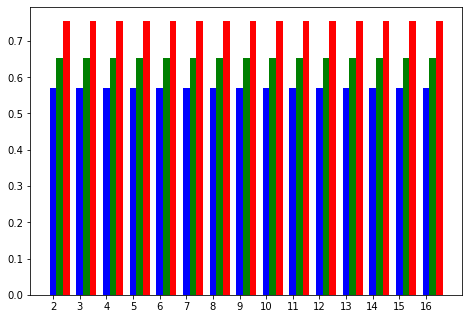

In [81]:
import numpy as np
import matplotlib.pyplot as plt

data = mset_oz_avg
X = np.arange(15)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

bars = [i for i in range(2,17)]
y_pos = np.arange(len(bars))
plt.xticks(y_pos, bars)#, rotation=45, fontweight='bold', fontsize='17', horizontalalignment='right')

In [ ]:
plt.plot()